<a href="https://colab.research.google.com/github/bagusetyaji/Data-Science/blob/main/Model_Evaluation_and_Hyperparameter_Tuning_(Pipeline).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Reading dataset

In [ ]:
import pandas as pd
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data',
header=None)

In [ ]:
from sklearn.preprocessing import LabelEncoder

X = df.loc[:, 2:].values
y = df.loc[:, 1].values

le = LabelEncoder()
y = le.fit_transform(y)

In [ ]:
le.transform(['B', 'M'])

array([0, 1])

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)

Combining transformers and estimators in a pipeline

In [ ]:
# Pipeline
# StandardScaler
# PCA
# Logistic Regression

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

pipe_lr = Pipeline([('scl', StandardScaler()),
                    ('pca', PCA(n_components=2)),
                    ('clf', LogisticRegression(random_state=1))])
pipe_lr.fit(X_train, y_train)

print('Test Accuracy: %.3f' % pipe_lr.score(X_test, y_test))

Test Accuracy: 0.947


Stratified K-Fold Cross Validation

In [ ]:
import numpy as np
from sklearn.model_selection import StratifiedKFold

kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
scores = []
for k, (train, test) in enumerate(kfold.split(X_train, y_train)):
    pipe_lr.fit(X_train[train], y_train[train])
    score = pipe_lr.score(X_train[test], y_train[test])
    scores.append(score)
    print('Fold: %s, Class dist.: %s, Acc: %.3f' % (k+1, np.bincount(y_train[train]), score))

print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

Fold: 1, Class dist.: [256 153], Acc: 0.891
Fold: 2, Class dist.: [256 153], Acc: 0.957
Fold: 3, Class dist.: [256 153], Acc: 0.978
Fold: 4, Class dist.: [256 153], Acc: 0.913
Fold: 5, Class dist.: [256 153], Acc: 0.957
Fold: 6, Class dist.: [257 153], Acc: 1.000
Fold: 7, Class dist.: [257 153], Acc: 0.933
Fold: 8, Class dist.: [257 153], Acc: 0.978
Fold: 9, Class dist.: [257 153], Acc: 0.889
Fold: 10, Class dist.: [257 153], Acc: 0.933
CV accuracy: 0.943 +/- 0.036


In [ ]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(estimator=pipe_lr,
                         X=X_train,
                         y=y_train,
                         cv=10,
                         n_jobs=1)
print('CV accuracy scores: %s' % scores)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy scores: [0.91304348 0.97826087 0.97826087 0.91304348 0.93478261 0.97777778
 0.93333333 0.95555556 0.97777778 0.95555556]
CV accuracy: 0.952 +/- 0.025


Diagnosing bias and variance problems with learning curves

(0.0, 450.0)

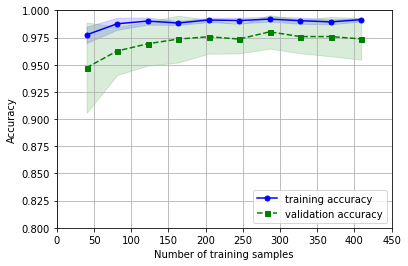

In [ ]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

pipe_lr = Pipeline([
          ('scl', StandardScaler()),
          ('clf', LogisticRegression(
                      penalty='l2', random_state=0))])

train_sizes, train_scores, test_scores = learning_curve(
                                              estimator=pipe_lr,
                                              X=X_train,
                                              y=y_train,
                                              train_sizes=np.linspace(0.1, 1.0, 10),
                                              cv=10,
                                              n_jobs=1)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean,
         color='blue', marker='o',
         markersize=5,
         label='training accuracy')

plt.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='validation accuracy')

plt.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1])
plt.xlim([0, 450])

Addressing overfitting and underfitting with validation curves

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

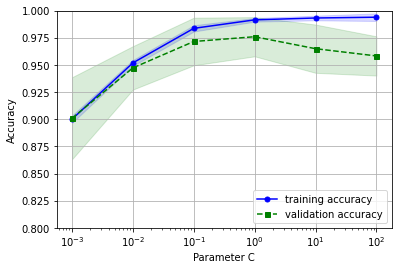

In [ ]:
from sklearn.model_selection import validation_curve

param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]

train_scores, test_scores = validation_curve(
                            estimator=pipe_lr,
                            X=X_train,
                            y=y_train,
                            param_name='clf__C',
                            param_range=param_range,
                            cv=10)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(param_range, train_mean,
         color='blue', marker='o',
         markersize=5,
         label='training accuracy')

plt.fill_between(param_range, 
                 train_mean + train_std,
                 train_mean - train_std, 
                 alpha=0.15, color='blue')

plt.plot(param_range, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='validation accuracy')

plt.fill_between(param_range, 
                 test_mean + test_std,
                 test_mean - test_std, 
                 alpha=0.15, color='green')

plt.grid()
plt.xscale('log')
plt.legend(loc='lower right')
plt.xlabel('Parameter C')
plt.ylabel('Accuracy')
plt.ylim([0.8, 1.0])
plt.show() 

Tuning hyperparameter via grid search

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

pipe_svc = Pipeline([('scl', StandardScaler()),
                     ('clf', SVC(random_state=1))])

param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]

param_grid = [{'clf__C': param_range,
               'clf__kernel': ['linear']},
              {'clf__C': param_range,
               'clf__gamma': param_range,
               'clf__kernel': ['rbf']}]
              
gs = GridSearchCV(estimator=pipe_svc,
                  param_grid=param_grid,
                  scoring='accuracy',
                  cv=10,
                  n_jobs=-1)

gs = gs.fit(X_train, y_train)

print(gs.best_score_)
print(gs.best_params_)

0.9781159420289856
{'clf__C': 0.1, 'clf__kernel': 'linear'}


In [ ]:
clf = gs.best_estimator_
clf.fit(X_train, y_train)
print('Test accuracy: %.3f' % clf.score(X_test, y_test))

Test accuracy: 0.965


Algorithm selection with nested cross-validation

In [ ]:
gs = GridSearchCV(estimator=pipe_svc,
                  param_grid=param_grid,
                  scoring='accuracy',
                  cv=2,
                  n_jobs=-1)

scores = cross_val_score(gs, X_train, y_train, scoring='accuracy', cv=5)

print('CV accuracy: %.3f +/- %.3f' % (
            np.mean(scores), np.std(scores)))

CV accuracy: 0.965 +/- 0.025


In [ ]:
from sklearn.tree import DecisionTreeClassifier

gs = GridSearchCV(
    estimator=DecisionTreeClassifier(random_state=0),
    param_grid=[
        {'max_depth' : [1, 2, 3, 4, 5, 6, 7, None]}],
    scoring='accuracy',
    cv=5)

scores = cross_val_score(gs,
                         X_train,
                         y_train,
                         scoring='accuracy',
                         cv=2)

print('CV accuracy : %.3f +/- %.3f' % (
                      np.mean(scores), np.std(scores)))

CV accuracy : 0.912 +/- 0.009


Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix

pipe_svc.fit(X_train, y_train)
y_pred = pipe_svc.predict(X_test)
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print(confmat)

[[71  1]
 [ 2 40]]


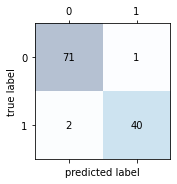

In [ ]:
fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)

for i in range(confmat.shape[0]):
  for j in range(confmat.shape[1]):
    ax.text(x=j, y=i,
            s=confmat[i, j],
            va='center', ha='center')

plt.xlabel('predicted label')
plt.ylabel('true label')
plt.show()

Optimizing the precision and recall of a classification model

In [ ]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score, f1_score

print('Precision: %.3f' % precision_score(
              y_true=y_test, y_pred=y_pred))
print('F1: %.3f' % f1_score(
              y_true=y_test, y_pred=y_pred))

Precision: 0.976
F1: 0.964


In [ ]:
from sklearn.metrics import make_scorer, f1_score

scorer = make_scorer(f1_score, pos_label=0)
gs = GridSearchCV(estimator=pipe_svc,
                  param_grid=param_grid,
                  scoring=scorer,
                  cv=10)

Plotting a receiver operating characteristic

<ipython-input-26-d79c639c1cc9>:27: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(mean_fpr, fpr, tpr)
<ipython-input-26-d79c639c1cc9>:27: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(mean_fpr, fpr, tpr)
<ipython-input-26-d79c639c1cc9>:27: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(mean_fpr, fpr, tpr)


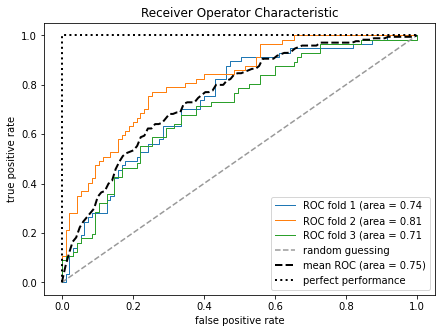

In [ ]:
from sklearn.metrics import roc_curve, auc
from scipy import interp

pipi_lr = Pipeline([('scl', StandardScaler()),
                    ('pca', PCA(n_components=2)),
                    ('clf', LogisticRegression(penalty='l2',
                                               random_state=0,
                                               C=100.0))])

X_train2 = X_train[:, [4, 14]]

cv = StratifiedKFold(n_splits=3,
                     shuffle=True,
                     random_state=1)

fig = plt.figure(figsize=(7, 5))
mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []

for i, (train, test) in enumerate(cv.split(X_train2, y_train)):
  probas = pipe_lr.fit(X_train2[train],
                       y_train[train]).predict_proba(X_train2[test])
  fpr, tpr, thresholds = roc_curve(y_train[test],
                                   probas[:, 1],
                                   pos_label=1)
  mean_tpr += interp(mean_fpr, fpr, tpr)
  mean_tpr[0] = 0.0
  roc_auc = auc(fpr, tpr)
  plt.plot(fpr,
           tpr,
           lw=1,
           label='ROC fold %d (area = %0.2f'
                  % (i+1, roc_auc))

plt.plot([0, 1],
         [0, 1],
         linestyle='--',
         color=(0.6, 0.6, 0.6),
         label='random guessing')

mean_tpr /= cv.get_n_splits()
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)

plt.plot(mean_fpr, mean_tpr,'k--',
         label='mean ROC (area = %0.2f)' % mean_auc, lw=2)

plt.plot([0, 0, 1],
         [0, 1, 1],
         lw=2,
         linestyle=':',
         color='black',
         label='perfect performance')

plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.title('Receiver Operator Characteristic')
plt.legend()
plt.show()

In [ ]:
pipe_lr = pipe_lr.fit(X_train2, y_train)
y_pred2 = pipe_lr.predict(X_test[:, [4, 14]])

In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

print('ROC AUC: %.3f' % roc_auc_score(y_true=y_test,
                                      y_score=y_pred2))
print('Accuracy: %.3f' % accuracy_score(y_true=y_test,
                                        y_pred=y_pred2))

ROC AUC: 0.662
Accuracy: 0.711


The Scoring metrics for multiclass classification

In [ ]:
pre_scorer = make_scorer(score_func=precision_score,
                         pos_label=1,
                         greater_is_better=True,
                         average='micro')
pre_scorer

make_scorer(precision_score, pos_label=1, average=micro)